In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# HW10

## Q1

A stochastic process is a mathematical model for systems that evolve randomly over time or space. It describes how systems evolve probabilistically over the index. A Gaussian Process is a specific stochastic process where any finite subset of variables follows a multivariate Gaussian distribution.

Variational Inference approximates intractable posterior distributions by optimizing over a simpler family of distributions. It is an alternative to MCMC methods. It approximates the posterior distribution $p(\theta|x)$ by a variational distribution $q(z)$. Maximizing the Evidence Lower Bound would bring $q(z)$ closer to $p(\theta|x)$. The ELBO is derived through Jensen’s inequality.

$\begin{align*}
\ln(p_\theta(x))&=\ln\left(E_{z\sim q_\phi(\cdot|x)}\left[\frac{p_\theta(x,z)}{q_\phi(z|x)}\right]\right)\geq E_{z\sim q_\phi(\cdot|x)}\left[\ln\left(\frac{p_\theta(x,z)}{q_\phi(z|x)}\right)\right]\\
\ln(p_\theta(x))-E_{z\sim q_\phi(\cdot|x)}\left[\ln\left(\frac{p_\theta(x,z)}{q_\phi(z|x)}\right)\right]&=D_{KL}(q_\phi(\cdot|x)||p_\theta(\cdot|x))\geq0\\
L(\phi,\theta;x)&=\ln(p_\theta(x))-D_{KL}(q_\phi(\cdot|x)||p_\theta(\cdot|x))
\end{align*}$

## Q2

In [2]:
data1 = pd.read_csv("data/stock.csv")
X1, Y1 = data1.iloc[:, 6].values, data1.iloc[:, 4].values

with pm.Model() as GP:
    amp_per = pm.HalfNormal("amp_per", sigma=50)
    len_per = pm.Gamma("len_per", alpha=3, beta=1)
    period = pm.Normal("period", mu=1, sigma=0.1)
    smooth = pm.Gamma("smooth", alpha=4, beta=2)
    cov_per = amp_per ** 2 * pm.gp.cov.Periodic(1, period, smooth) * pm.gp.cov.Matern52(1, len_per)
    gp = pm.gp.Marginal(cov_func=cov_per)
    amp_noise = pm.HalfNormal("amp_noise", sigma=25)
    len_noise = pm.Gamma("len_noise", alpha=2, beta=2)
    sigma = pm.HalfNormal("sigma", sigma=5)
    cov_noise = amp_noise ** 2 * pm.gp.cov.Matern32(1, len_noise) + pm.gp.cov.WhiteNoise(sigma)
    y = gp.marginal_likelihood("y", X=X1.reshape(-1, 1), y=Y1, sigma=cov_noise)
    idata1 = pm.sample(draws=500, chains=2, tune=50, random_seed=365)

az.summary(idata1, round_to=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [amp_per, len_per, period, smooth, amp_noise, len_noise, sigma]


Sampling 2 chains for 50 tune and 500 draw iterations (100 + 1_000 draws total) took 4150 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amp_noise,1.645,0.359,1.160,2.345,0.040,0.022,78.056,351.034,1.033
amp_per,39.962,12.772,18.500,62.840,0.701,0.576,339.062,581.289,1.000
len_noise,0.020,0.005,0.013,0.029,0.001,0.000,71.279,362.592,1.034
len_per,2.939,1.537,0.551,5.685,0.108,0.110,180.624,103.864,1.010
period,0.965,0.124,0.711,1.160,0.010,0.007,212.764,493.415,1.026
sigma,0.469,0.025,0.422,0.515,0.001,0.001,518.043,743.151,1.011
smooth,1.824,1.019,0.699,3.715,0.127,0.047,32.917,366.348,1.059


array([[<Axes: title={'center': 'amp_noise'}>,
        <Axes: title={'center': 'amp_noise'}>],
       [<Axes: title={'center': 'amp_per'}>,
        <Axes: title={'center': 'amp_per'}>],
       [<Axes: title={'center': 'len_noise'}>,
        <Axes: title={'center': 'len_noise'}>],
       [<Axes: title={'center': 'len_per'}>,
        <Axes: title={'center': 'len_per'}>],
       [<Axes: title={'center': 'period'}>,
        <Axes: title={'center': 'period'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'smooth'}>,
        <Axes: title={'center': 'smooth'}>]], dtype=object)

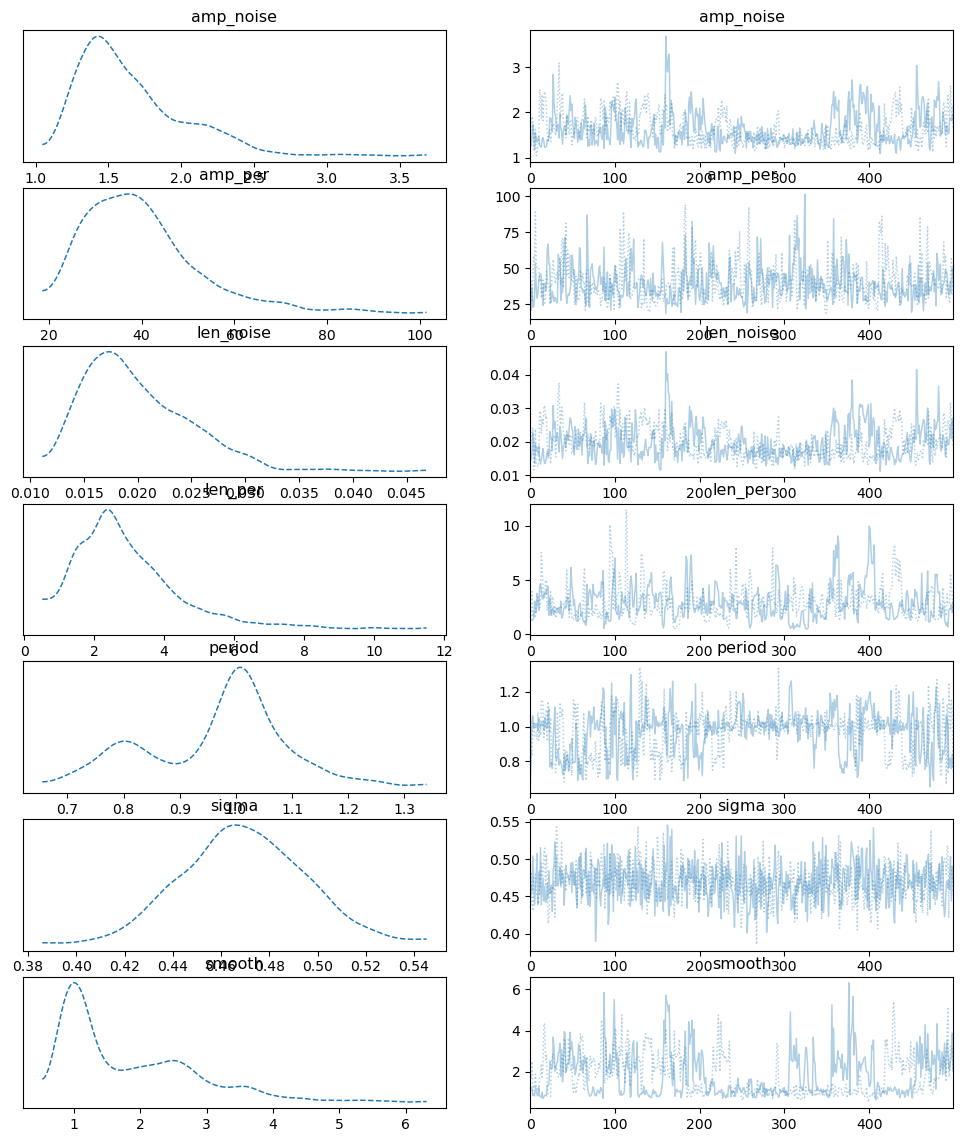

In [3]:
az.plot_trace(idata1, combined=True)

## Q3

In [4]:
data2 = pd.read_csv("data/diabetes.csv")
X2, Y2 = data2.iloc[:, :8].values, data2.iloc[:, 8].values

with pm.Model() as VI:
    x = pm.Data("x", X2, mutable=True)
    y_obs = pm.Data("y_data", Y2, mutable=True)
    wt1 = pm.Normal("wt1", mu=0, sigma=1, shape=(X2.shape[1], 10))
    bias1 = pm.Normal("bias1", mu=0, sigma=1, shape=10)
    wt2 = pm.Normal("wt2", mu=0, sigma=1, shape=10)
    bias2 = pm.Normal("bias2", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    y = pm.Normal("y", mu=pm.math.tanh(x@wt1+bias1)@wt2+bias2, sigma=sigma, observed=y_obs)
    approx = pm.fit(n=30000, method="advi")
    idata2 = approx.sample(draws=10000, random_seed=365)

az.summary(idata2, round_to=3)

Finished [100%]: Average Loss = 593.14
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias1[0],0.034,1.079,-1.961,2.070,0.011,0.008,10054.381,9677.829,NaN
bias1[1],0.036,1.090,-1.973,2.046,0.011,0.008,9405.790,10033.200,NaN
bias1[2],0.001,1.103,-2.129,1.998,0.011,0.008,9978.165,9537.400,NaN
bias1[3],-0.014,1.092,-1.996,2.090,0.011,0.008,10189.192,9405.462,NaN
bias1[4],-0.020,1.098,-2.077,2.058,0.011,0.008,9724.049,10131.401,NaN
...,...,...,...,...,...,...,...,...,...
wt2[5],0.003,0.045,-0.082,0.084,0.000,0.000,10112.634,9634.365,NaN
wt2[6],-0.001,0.042,-0.080,0.078,0.000,0.000,10149.230,9583.750,NaN
wt2[7],-0.004,0.043,-0.083,0.078,0.000,0.000,10027.412,8202.111,NaN
wt2[8],0.008,0.043,-0.073,0.087,0.000,0.000,9949.184,9124.887,NaN


array([[<Axes: title={'center': 'bias1'}>,
        <Axes: title={'center': 'bias1'}>],
       [<Axes: title={'center': 'bias2'}>,
        <Axes: title={'center': 'bias2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'wt1'}>, <Axes: title={'center': 'wt1'}>],
       [<Axes: title={'center': 'wt2'}>, <Axes: title={'center': 'wt2'}>]],
      dtype=object)

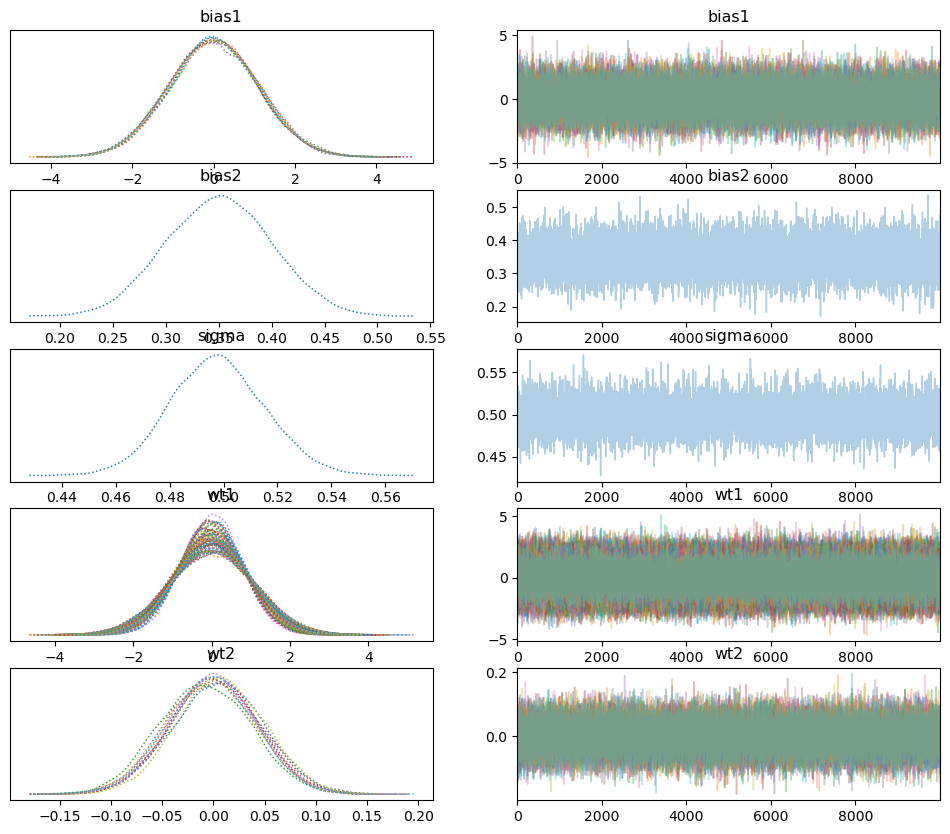

In [5]:
az.plot_trace(idata2, combined=True)